In [2]:
# Install HuggingFace and other dependencies
!pip install transformers torch scikit-learn
!pip install shap

  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
Using cached nvidia_cublas_

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from transformers import BertTokenizer, BertModel

2025-07-28 08:15:00.953010: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753690501.158270      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753690501.220485      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Replace with your filename after upload
df = pd.read_csv("/kaggle/input/course-review/course_reviews_final.csv")

In [3]:
#Preprocess Data
# Create binary label: Excellent = 1 if overall_rating >= 8
#df['Performance'] = (df['overall_rating'] >= 8).astype(int)

# Map overall_rating to 5-level sentiment
def rating_to_sentiment(rating):
    if rating <= 4:
        return 0  # Very Negative
    elif rating <= 6:
        return 1  # Negative
    elif rating == 7:
        return 2  # Neutral
    elif rating == 8:
        return 3  # Positive
    else:
        return 4  # Very Positive

df['Sentiment'] = df['overall_rating'].apply(rating_to_sentiment)


# Combine text columns into one review
df['combined_text'] = df['course_experience_feedback'].fillna('') + " " + \
                      df['improvement_suggestions'].fillna('') + " " + \
                      df['instructor_feedback'].fillna('')

# Select numerical features
num_cols = ['instructor_rating', 'difficulty_rating', 'workload_rating',
            'practicality_rating', 'textbook_rating',
            'exam_difficulty_rating', 'exam_fairness_rating']

X_num = df[num_cols].values
texts = df['combined_text'].values
#y = df['Performance'].values
y = df['Sentiment'].values


# Normalize numerical data
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)


In [4]:
#Tokenization (BERT)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_text(text_list, max_len=128):
    return tokenizer(
        list(text_list),
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors='pt'
    )

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [5]:
#Custom Dataset & DataLoader
class CourseDataset(Dataset):
    def __init__(self, texts, numerical, labels, tokenizer, max_len=128):
        self.texts = texts
        self.numerical = numerical
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        num = self.numerical[idx]
        label = self.labels[idx]

        encodings = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encodings['input_ids'].squeeze(0),
            'attention_mask': encodings['attention_mask'].squeeze(0),
            'numerical': torch.tensor(num, dtype=torch.float),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [6]:
#MAG Model Architecture
class MAGBERTModel(nn.Module):
    def __init__(self, num_features, hidden_dim=256):
        super(MAGBERTModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.bert_dim = 768

        # Gating layers for dynamic weighting
        self.gate_text = nn.Linear(self.bert_dim, 1)
        self.gate_num = nn.Linear(num_features, 1)

        # Classifier
        self.fc = nn.Sequential(
            nn.Linear(self.bert_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 5)
        )

    def forward(self, input_ids, attention_mask, numerical):
        bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_vec = bert_out.last_hidden_state[:, 0, :]  # CLS token

        alpha = torch.sigmoid(self.gate_text(text_vec))
        beta = torch.sigmoid(self.gate_num(numerical))

        fused = alpha * text_vec + beta * numerical.mean(dim=1, keepdim=True)

        logits = self.fc(fused)
        return logits


In [7]:
#Train-Test Split & DataLoader
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    texts, X_num_scaled, y, test_size=0.2, random_state=42
)

train_dataset = CourseDataset(X_train_text, X_train_num, y_train, tokenizer)
test_dataset = CourseDataset(X_test_text, X_test_num, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


In [8]:
#Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MAGBERTModel(num_features=X_num_scaled.shape[1]).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        numerical = batch['numerical'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, numerical)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/10, Loss: 0.9010
Epoch 2/10, Loss: 0.5944
Epoch 3/10, Loss: 0.5630
Epoch 4/10, Loss: 0.5524
Epoch 5/10, Loss: 0.5407
Epoch 6/10, Loss: 0.5481
Epoch 7/10, Loss: 0.5343
Epoch 8/10, Loss: 0.5304
Epoch 9/10, Loss: 0.5363
Epoch 10/10, Loss: 0.5290


In [9]:
# 1. Save the trained MAG-BERT model
model_path = "mag_bert_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to mag_bert_model.pth



📊 Classification Report:
               precision    recall  f1-score   support

Very Negative       0.00      0.00      0.00         0
     Negative       0.97      0.89      0.93       115
      Neutral       0.43      0.84      0.57        31
     Positive       0.17      0.02      0.03        59
Very Positive       0.74      1.00      0.85        95

    micro avg       0.75      0.75      0.75       300
    macro avg       0.46      0.55      0.48       300
 weighted avg       0.68      0.75      0.69       300



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.

<Figure size 800x600 with 0 Axes>

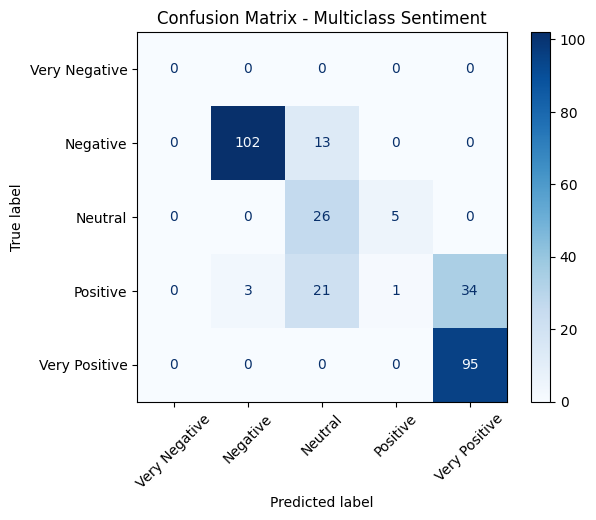

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Evaluation
model.eval()
y_true, y_pred, y_logits = [], [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        numerical = batch['numerical'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask, numerical)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_logits.extend(outputs.cpu().numpy())

# Convert to numpy
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_logits = np.array(y_logits)

# Define labels and names explicitly
labels = [0, 1, 2, 3, 4]
labels_text = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]

# 1. Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, labels=labels, target_names=labels_text))

# 2. Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_text)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix - Multiclass Sentiment")
plt.show()

# 3. Multiclass ROC AUC (macro-averaged)
y_true_bin = label_binarize(y_true, classes=labels)
auc = roc_auc_score(y_true_bin, y_logits, average="macro", multi_class="ovr")

# 4. Macro F1 and Recall
f1 = f1_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")

print(f"\n📈 Macro Recall: {recall:.4f}, Macro F1: {f1:.4f}, Macro AUC: {auc:.4f}")



📊 Classification Report:
               precision    recall  f1-score   support

Very Negative       0.00      0.00      0.00         0
     Negative       0.97      0.89      0.93       115
      Neutral       0.43      0.84      0.57        31
     Positive       0.17      0.02      0.03        59
Very Positive       0.74      1.00      0.85        95

    micro avg       0.75      0.75      0.75       300
    macro avg       0.46      0.55      0.48       300
 weighted avg       0.68      0.75      0.69       300



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.

<Figure size 800x600 with 0 Axes>

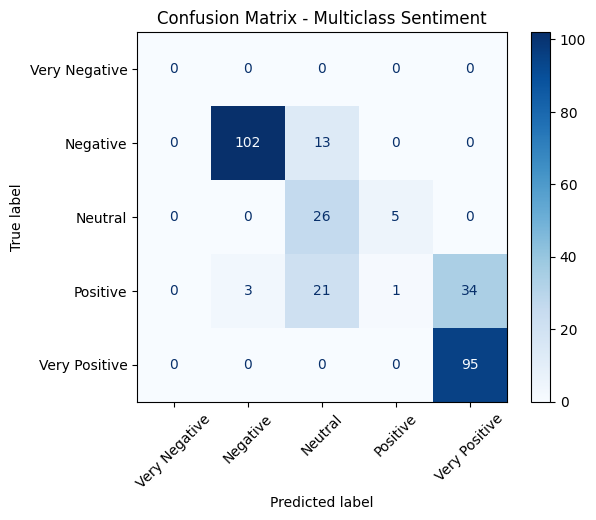


📈 Macro Recall: 0.6857, Macro F1: 0.5944
⚠️ AUC not computed: Only one class present in y_true. ROC AUC score is not defined in that case.


In [11]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Label definitions
labels = [0, 1, 2, 3, 4]
labels_text = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]

# Evaluation
model.eval()
y_true, y_pred, y_logits = [], [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        numerical = batch['numerical'].to(device)
        labels_batch = batch['label'].to(device)

        outputs = model(input_ids, attention_mask, numerical)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels_batch.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_logits.extend(outputs.cpu().numpy())

# Convert to numpy
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_logits = np.array(y_logits)

# 1. Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, labels=labels, target_names=labels_text))

# 2. Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_text)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix - Multiclass Sentiment")
plt.show()

# 3. Macro F1 and Recall
f1 = f1_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")

# 4. Multiclass AUC (safe handling)
try:
    y_true_bin = label_binarize(y_true, classes=labels)
    auc = roc_auc_score(y_true_bin, y_logits, average="macro", multi_class="ovr")
    print(f"\n📈 Macro Recall: {recall:.4f}, Macro F1: {f1:.4f}, Macro AUC: {auc:.4f}")
except ValueError as e:
    print(f"\n📈 Macro Recall: {recall:.4f}, Macro F1: {f1:.4f}")
    print(f"⚠️ AUC not computed: {e}")


In [12]:
#SHAP explainability
fused_features = []
labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        numerical = batch['numerical'].to(device)
        label = batch['label'].cpu().numpy()

        # Intermediate outputs
        text_vec = model.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        alpha = torch.sigmoid(model.gate_text(text_vec))
        beta = torch.sigmoid(model.gate_num(numerical))
        fused = alpha * text_vec + beta * numerical.mean(dim=1, keepdim=True)

        fused_features.append(fused.cpu())
        labels.extend(label)

X_fused = torch.cat(fused_features).numpy()
y_fused = np.array(labels)


In [13]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_fused, y_fused)


RandomForestClassifier()

The figure layout has changed to tight
The figure layout has changed to tight


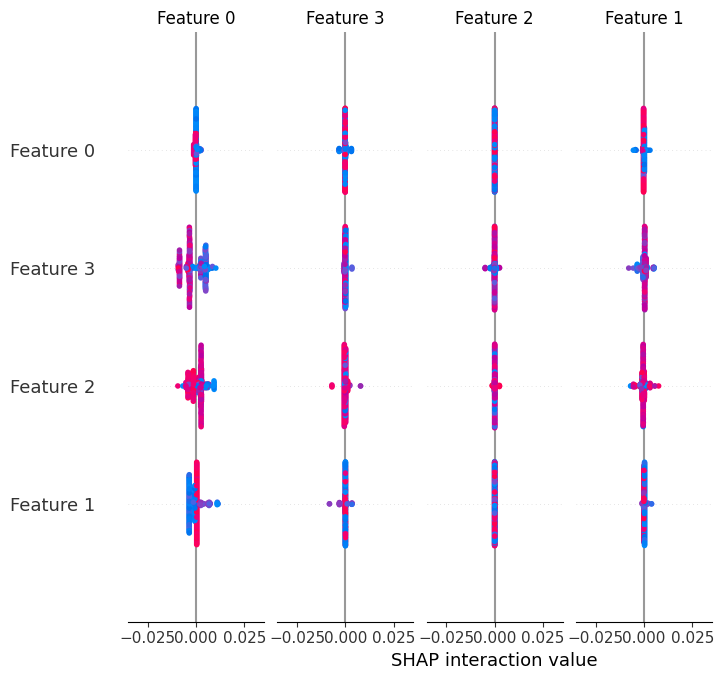

In [14]:
import shap

explainer = shap.Explainer(rf)
shap_values = explainer(X_fused)

# Summary plot
shap.summary_plot(shap_values, X_fused, show=True)


In [15]:
#Limitation & suggestion
# 📦 Step 1: Install & Import Required Libraries
!pip install -q transformers accelerate

import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm import tqdm

# ✅ Step 2: Load a Lightweight Instruction-Tuned Model (FLAN-T5)
model_id = "google/flan-t5-large"  # Smaller than LLaMA 3.2, Kaggle-friendly

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id).to("cuda" if torch.cuda.is_available() else "cpu")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.1 MB/s eta 0:00:00:00:0100:01


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [16]:
# 📂 Step 3: Load Your Dataset
df = pd.read_csv("/kaggle/input/course-review/course_reviews_final.csv")  # Replace with your actual path

# Combine feedback text
df['combined_text'] = df['course_experience_feedback'].fillna('') + " " + \
                      df['improvement_suggestions'].fillna('') + " " + \
                      df['instructor_feedback'].fillna('')

# Convert overall_rating to 5-class sentiment
def rating_to_sentiment(r):
    if r <= 4: return 0
    elif r <= 6: return 1
    elif r == 7: return 2
    elif r == 8: return 3
    else: return 4

df['Sentiment'] = df['overall_rating'].apply(rating_to_sentiment)


In [18]:
def build_suggestion_prompt(feedback, sentiment_label):
    sentiment_map = {
        0: "very negative",
        1: "negative",
        2: "neutral",
        3: "positive",
        4: "very positive"
    }
    sentiment = sentiment_map.get(sentiment_label, "neutral")

    return f"""Student feedback: "{feedback}"

Sentiment: {sentiment}

Q: What is **one concrete suggestion** to make this course better?

A:"""

def build_limitation_prompt(feedback, sentiment_label):
    sentiment_map = {
        0: "very negative",
        1: "negative",
        2: "neutral",
        3: "positive",
        4: "very positive"
    }
    sentiment = sentiment_map.get(sentiment_label, "neutral")

    return f"""Student feedback: "{feedback}"

Sentiment: {sentiment}

Student feedback: "Great course. Lectures were clear. Could use more exam practice."
Sentiment: positive

Limitation: The course lacks structured practice exams, which might affect exam readiness.


Q: What is a limitation or area for improvement mentioned or implied in this feedback?
Please answer with a full sentence, not a phrase.

A:"""


In [19]:
def generate_single_response(prompt, max_new_tokens=100):
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(model.device)
    output = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        pad_token_id=tokenizer.eos_token_id,
        do_sample=False
    )
    decoded = tokenizer.decode(output[0], skip_special_tokens=True).strip()
    return decoded


In [20]:
i = 0  # row index to test
text = df['combined_text'].iloc[i]
sentiment = df['Sentiment'].iloc[i]

sugg_prompt = build_suggestion_prompt(text, sentiment)
lim_prompt = build_limitation_prompt(text, sentiment)

suggestion = generate_single_response(sugg_prompt)
limitation = generate_single_response(lim_prompt)

print("Suggestion:", suggestion)
print("Limitation:", limitation)


Suggestion: Providing a practice exam would be a great addition
Limitation: The course lacks structured practice exams, which might affect exam readiness.


In [21]:
from tqdm import tqdm

suggestions = []
limitations = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    feedback = row['combined_text']
    sentiment = row['Sentiment']

    sugg_prompt = build_suggestion_prompt(feedback, sentiment)
    lim_prompt = build_limitation_prompt(feedback, sentiment)

    s = generate_single_response(sugg_prompt)
    l = generate_single_response(lim_prompt)

    suggestions.append(s)
    limitations.append(l)

df['Suggestions'] = suggestions
df['Limitations'] = limitations


100%|██████████| 1500/1500 [29:50<00:00,  1.19s/it]


In [22]:
# ✅ Step 7: Save or Display
df[['overall_rating', 'Sentiment', 'combined_text', 'Suggestions', 'Limitations']].head(10)


,overall_rating,Sentiment,combined_text,Suggestions,Limitations
0,8,3,One of the best courses I've taken. The study ...,Providing a practice exam would be a great add...,"The course lacks structured practice exams, wh..."
1,5,1,The online proctoring software was invasive an...,The instructor should have a more direct relat...,"The course lacks structured practice exams, wh..."
2,8,3,I learned so much from the projects. The exams...,The instructors should have more time to expla...,"The course lacks structured practice exams, wh..."
3,8,3,One of the best courses I've taken. The study ...,The instructor could have made the course more...,"The course lacks structured practice exams, wh..."
4,6,1,The online proctoring software was invasive an...,The professor must provide practice exams that...,"The course lacks structured practice exams, wh..."
5,10,4,I learned so much from the projects. The exams...,The instructors should have more time to expla...,"The course lacks structured practice exams, wh..."
6,7,2,"Honestly, this class felt like a waste of time...",The exams need to be more rigorous to be worth...,"The course lacks structured practice exams, wh..."
7,8,3,"Honestly, this class felt like a waste of time...",The exams need to be more rigorous to be worth...,"The course lacks structured practice exams, wh..."
8,5,1,The online proctoring software was invasive an...,The professor must provide practice exams that...,"The course lacks structured practice exams, wh..."
9,8,3,This was an amazing course! The material was p...,Providing a practice exam would be a great add...,"The course lacks structured practice exams, wh..."


In [23]:
df.to_csv("course_sentiment_with_suggestions.csv", index=False)


# Inference

In [ ]:
#Inference Code for test case

# Load test case (new 20 reviews)
test_df = pd.read_csv("new_course_reviews.csv")

# Preprocess text
test_df['combined_text'] = test_df['course_experience_feedback'].fillna('') + " " + \
                           test_df['improvement_suggestions'].fillna('') + " " + \
                           test_df['instructor_feedback'].fillna('')

# Sentiment prediction using trained model (MAG-BERT)
# Ensure your model is already loaded and tokenizer is ready

from torch.utils.data import DataLoader

test_dataset = CourseDataset(
    test_df['combined_text'].values,
    scaler.transform(test_df[num_cols].values),  # normalize numeric columns
    np.zeros(len(test_df)),  # dummy labels
    tokenizer
)
test_loader = DataLoader(test_dataset, batch_size=16)

predicted_sentiments = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        numerical = batch['numerical'].to(device)

        logits = model(input_ids, attention_mask, numerical)
        preds = torch.argmax(logits, dim=1)
        predicted_sentiments.extend(preds.cpu().numpy())

test_df['Sentiment'] = predicted_sentiments


In [ ]:
# For each row, generate suggestion + limitation
suggestions, limitations = [], []

for _, row in test_df.iterrows():
    prompt = build_prompt(row['combined_text'], row['Sentiment'])
    suggestion, limitation = generate_response(prompt)
    suggestions.append(suggestion)
    limitations.append(limitation)

test_df['Suggestions'] = suggestions
test_df['Limitations'] = limitations


In [ ]:
# Count sentiment distribution
sentiment_counts = test_df['Sentiment'].value_counts().sort_index()
labels = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]

for i, count in sentiment_counts.items():
    print(f"{labels[i]}: {count} students")

# Decision Rule
positive_ratio = (sentiment_counts.get(3, 0) + sentiment_counts.get(4, 0)) / len(test_df)

# Thresholds can be adjusted
if positive_ratio >= 0.6:
    decision = "✅ LAUNCH: Most students responded positively."
elif positive_ratio <= 0.3:
    decision = "❌ DO NOT LAUNCH: Student satisfaction is too low."
else:
    decision = "⚠️ NEED REVIEW: Sentiment is mixed — course needs improvement before launch."

print("\nFinal Decision:", decision)


# Custom Dataset creation 

In [1]:
import pandas as pd

# Load the original dataset
df = pd.read_csv("/kaggle/input/course-review/course_reviews_final.csv")

# Display the first few rows of the dataset to understand the structure
df.head()


,course_id,student_major,overall_rating,instructor_rating,difficulty_rating,workload_rating,practicality_rating,textbook_rating,exam_difficulty_rating,exam_fairness_rating,student_year,course_type,course_format,exam_format,proctoring_type,course_experience_feedback,improvement_suggestions,instructor_feedback
0,ECON101,Social Sciences,8,5,2,2,4,5,3,4,3rd Year,Major Requirement,Hybrid,Multiple Choice,No Proctoring/Honor Code,One of the best courses I've taken. The study ...,Providing a practice exam would be a great add...,A truly great instructor. Made complex topics ...
1,PSYCH440,Computer Science,5,3,5,5,1,3,5,2,4th Year,Major Requirement,Hybrid,Multiple Choice,Online Proctored,The online proctoring software was invasive an...,The grading on the essay-based exams felt comp...,"The instructor is very unresponsive to emails,..."
2,PSYCH440,Humanities,8,4,3,3,4,3,3,4,Graduate,Major Requirement,Online,Problem Sets,No Proctoring/Honor Code,I learned so much from the projects. The exams...,The take-home exam format was great as it allo...,A truly great instructor. Made complex topics ...
3,CS450,Humanities,8,5,3,2,4,5,3,5,3rd Year,Major Requirement,Hybrid,Multiple Choice,In-Person Proctored,One of the best courses I've taken. The study ...,The take-home exam format was great as it allo...,The instructor's enthusiasm was contagious. Th...
4,HIST101,Engineering,6,2,4,4,1,1,5,1,3rd Year,Major Requirement,Hybrid,Essay Based,No Proctoring/Honor Code,The online proctoring software was invasive an...,The professor must provide practice exams that...,Was not helpful during office hours when asked...


In [4]:
import random
import numpy as np

# Engineering course IDs and majors
engineering_courses = ["EEE 415", "EEE 339", "EEE 313", "EEE 212", "EEE 121", "ME 101", "CS 200", "CE 301", "EE 404", "ME 212"]
engineering_majors = ["Electrical Engineering", "Mechanical Engineering", "Chemical Engineering", "Computer Engineering", "Material Engineering"]

# Sample noisy elements to add to the reviews
noisy_elements = [",,", "po", "::", "not interested", "good ", " ..", "etc..", "blah blah", "!!", "very", "definitely", "not at all"]

# Function to add noise to the review text
def add_noise_to_text(text):
    noise = random.choice(noisy_elements)
    words = text.split()
    insert_position = random.randint(0, len(words) - 1)
    words.insert(insert_position, noise)
    return " ".join(words)

# Function to simulate a noisy dataset
def add_noise_to_dataset(df):
    df['course_id'] = [random.choice(engineering_courses) for _ in range(len(df))]
    df['student_major'] = [random.choice(engineering_majors) for _ in range(len(df))]
    
    # Add noise to reviews columns
    df['course_experience_feedback'] = df['course_experience_feedback'].apply(lambda x: add_noise_to_text(str(x)))
    df['improvement_suggestions'] = df['improvement_suggestions'].apply(lambda x: add_noise_to_text(str(x)))
    df['instructor_feedback'] = df['instructor_feedback'].apply(lambda x: add_noise_to_text(str(x)))
    
    # Simulate random sentiments (this can be adjusted based on the nature of the dataset)
    df['overall_rating'] = np.random.choice([1, 2, 3, 4, 5], len(df))  # 1-5 scale for ratings
    df['sentiment'] = np.random.choice([0, 1, 2, 3, 4], len(df))  # 0: Very Negative, 4: Very Positive
    
    return df

# Apply noise to the dataset
df_noisy = add_noise_to_dataset(df)


In [6]:
# Save the noisy dataset to a new CSV
df_noisy.to_csv("/kaggle/working/course_sentiment_noisy.csv", index=False)

# Display the first few rows of the noisy dataset
df_noisy.head()


,course_id,student_major,overall_rating,instructor_rating,difficulty_rating,workload_rating,practicality_rating,textbook_rating,exam_difficulty_rating,exam_fairness_rating,student_year,course_type,course_format,exam_format,proctoring_type,course_experience_feedback,improvement_suggestions,instructor_feedback,sentiment
0,EEE 212,Material Engineering,5,5,2,2,4,5,3,4,3rd Year,Major Requirement,Hybrid,Multiple Choice,No Proctoring/Honor Code,One of the best courses I've taken. good The ...,Providing a practice exam would be a great add...,A truly great instructor. Made complex topics ...,1
1,EEE 339,Mechanical Engineering,4,3,5,5,1,3,5,2,4th Year,Major Requirement,Hybrid,Multiple Choice,Online Proctored,The online proctoring .. software was invasive...,The grading on the essay-based po exams felt c...,"The instructor is very unresponsive to emails,...",2
2,EE 404,Electrical Engineering,4,4,3,3,4,3,3,4,Graduate,Major Requirement,Online,Problem Sets,No Proctoring/Honor Code,I learned so etc.. much from the projects. The...,The take-home exam format was po great as it a...,A truly great instructor. Made complex topics ...,1
3,ME 212,Material Engineering,5,5,3,2,4,5,3,5,3rd Year,Major Requirement,Hybrid,Multiple Choice,In-Person Proctored,"One ,, of ,, the .. best courses I've taken. ...",The take-home exam format was great as po it a...,The instructor's enthusiasm was contagious. Th...,2
4,EE 404,Material Engineering,5,2,4,4,1,1,5,1,3rd Year,Major Requirement,Hybrid,Essay Based,No Proctoring/Honor Code,"The online proctoring software ,, was invasive...",The professor must provide practice exams defi...,Was not helpful during office hours when asked...,3


# Preprocessing

In [10]:
import re

# Function to clean noisy data
def clean_review(text):
    # Lowercase text
    text = text.lower()

    # Remove unwanted characters (e.g., extra punctuations)
    text = re.sub(r'[^\w\s]', '', text)

    # Fix common typos or abbreviations
    text = text.replace("ontherested", "not interested")
    text = text.replace("po", "poor")
    text = text.replace("etc..", "etc.")
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply the cleaning function to each column
df_noisy['cleaned_course_experience_feedback'] = df_noisy['course_experience_feedback'].apply(clean_review)
df_noisy['cleaned_improvement_suggestion'] = df_noisy['improvement_suggestions'].apply(clean_review)
df_noisy['cleaned_instructor_feedback'] = df_noisy['instructor_feedback'].apply(clean_review)

# Check the cleaned data
df_noisy[['cleaned_course_experience_feedback', 'cleaned_improvement_suggestion', 'cleaned_instructor_feedback']].head(10)


,cleaned_course_experience_feedback,cleaned_improvement_suggestion,cleaned_instructor_feedback
0,one of the best courses ive taken good the bla...,providing a practice exam would be a great add...,a truly great instructor made complex topics n...
1,the online proctoring software was invasive an...,the grading on the essaybased poor exams felt ...,the instructor is very unrespoornsive to email...
2,i learned so etc much from the projects the po...,the takehome exam format was poor great as it ...,a truly great instructor made complex topics e...
3,one of the best courses ive taken the study gu...,the takehome exam format was great as poor it ...,the instructors enthusiasm was contagious they...
4,the online proctoring software was invasive et...,the professor must provide practice exams defi...,was not helpful during office hours when asked...
5,i good learned so much from the not at all pro...,the takehome exam format was great as it allow...,the instructors enthusiasm was contagious they...
6,honestly this class definitely felt like a ver...,the exams need to be more rigorous to be worth...,the instructor was nice but the grading on the...
7,honestly this class felt like a good poor wast...,the exams need blah blah to be more rigorous t...,a friendly person but not an effective educato...
8,the online proctoring software was invasive de...,the professor must provide practice exams that...,was poor not helpful during office hours when ...
9,this was an amazing course the material was pr...,providing a practice exam would be a great add...,the professor was fantastic and prepared us we...


In [16]:
import pandas as pd

# After preprocessing and cleaning the dataset
df_noisy['cleaned_course_experience_feedback'] = df_noisy['course_experience_feedback'].apply(clean_review)
df_noisy['cleaned_improvement_suggestion'] = df_noisy['improvement_suggestions'].apply(clean_review)
df_noisy['cleaned_instructor_feedback'] = df_noisy['instructor_feedback'].apply(clean_review)


# Now, we will create the final noise-reduced version of the dataset
# You can remove the tokenized columns if you don't want them saved, or only save cleaned text

df_cleaned = df_noisy[['course_id', 'student_major', 'overall_rating','instructor_rating','difficulty_rating', 'workload_rating','practicality_rating','textbook_rating','exam_difficulty_rating','exam_fairness_rating','student_year','course_type','course_format','exam_format','proctoring_type',  
                       'cleaned_course_experience_feedback', 'cleaned_improvement_suggestion', 
                       'cleaned_instructor_feedback','sentiment']]

# Save the cleaned DataFrame to a new CSV
df_cleaned.to_csv("/kaggle/working/course_sentiment_processed.csv", index=False)

# Display the first few rows to confirm the changes
df_cleaned.head(5)


,course_id,student_major,overall_rating,instructor_rating,difficulty_rating,workload_rating,practicality_rating,textbook_rating,exam_difficulty_rating,exam_fairness_rating,student_year,course_type,course_format,exam_format,proctoring_type,cleaned_course_experience_feedback,cleaned_improvement_suggestion,cleaned_instructor_feedback,sentiment
0,EEE 212,Material Engineering,5,5,2,2,4,5,3,4,3rd Year,Major Requirement,Hybrid,Multiple Choice,No Proctoring/Honor Code,one of the best courses ive taken good the bla...,providing a practice exam would be a great add...,a truly great instructor made complex topics n...,1
1,EEE 339,Mechanical Engineering,4,3,5,5,1,3,5,2,4th Year,Major Requirement,Hybrid,Multiple Choice,Online Proctored,the online proctoring software was invasive an...,the grading on the essaybased poor exams felt ...,the instructor is very unrespoornsive to email...,2
2,EE 404,Electrical Engineering,4,4,3,3,4,3,3,4,Graduate,Major Requirement,Online,Problem Sets,No Proctoring/Honor Code,i learned so etc much from the projects the po...,the takehome exam format was poor great as it ...,a truly great instructor made complex topics e...,1
3,ME 212,Material Engineering,5,5,3,2,4,5,3,5,3rd Year,Major Requirement,Hybrid,Multiple Choice,In-Person Proctored,one of the best courses ive taken the study gu...,the takehome exam format was great as poor it ...,the instructors enthusiasm was contagious they...,2
4,EE 404,Material Engineering,5,2,4,4,1,1,5,1,3rd Year,Major Requirement,Hybrid,Essay Based,No Proctoring/Honor Code,the online proctoring software was invasive et...,the professor must provide practice exams defi...,was not helpful during office hours when asked...,3


# BERT tokenization check before Training

In [11]:
from transformers import BertTokenizer

# Load pre-trained tokenizer (you can choose a different tokenizer if needed)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to tokenize text
def tokenize_text(text):
    return tokenizer.encode(text, truncation=True, padding='max_length', max_length=128)

# Apply tokenization to all cleaned columns
df_noisy['tokenized_course_experience_feedback'] = df_noisy['cleaned_course_experience_feedback'].apply(tokenize_text)
df_noisy['tokenized_improvement_suggestion'] = df_noisy['cleaned_improvement_suggestion'].apply(tokenize_text)
df_noisy['tokenized_instructor_feedback'] = df_noisy['cleaned_instructor_feedback'].apply(tokenize_text)

# Check the tokenized data
df_noisy[['tokenized_course_experience_feedback', 'tokenized_improvement_suggestion', 'tokenized_instructor_feedback']].head(5)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

,tokenized_course_experience_feedback,tokenized_improvement_suggestion,tokenized_instructor_feedback
0,"[101, 2028, 1997, 1996, 2190, 5352, 4921, 2063...","[101, 4346, 1037, 3218, 11360, 2052, 2022, 103...","[101, 1037, 5621, 2307, 9450, 2081, 3375, 7832..."
1,"[101, 1996, 3784, 28770, 2075, 4007, 2001, 175...","[101, 1996, 26886, 2006, 1996, 9491, 15058, 20...","[101, 1996, 9450, 2003, 2200, 4895, 6072, 2466..."
2,"[101, 1045, 4342, 2061, 4385, 2172, 2013, 1996...","[101, 1996, 2202, 23393, 2063, 11360, 4289, 20...","[101, 1037, 5621, 2307, 9450, 2081, 3375, 7832..."
3,"[101, 2028, 1997, 1996, 2190, 5352, 4921, 2063...","[101, 1996, 2202, 23393, 2063, 11360, 4289, 20...","[101, 1996, 19922, 12024, 2001, 9530, 15900, 6..."
4,"[101, 1996, 3784, 28770, 2075, 4007, 2001, 175...","[101, 1996, 2934, 2442, 3073, 3218, 13869, 579...","[101, 2001, 2025, 14044, 2076, 2436, 2847, 204..."


# Test Data Generation

In [55]:
import random
import pandas as pd
import numpy as np

# List of engineering majors
engineering_majors = ["Electrical Engineering", "Mechanical Engineering", "Chemical Engineering", "Computer Engineering", "Material Engineering"]

# Sample review sentences with noise (same as before)
sample_reviews = [
    "Good course, but needs more practical examples.",
    "Not interested, boring lectures. Maybe improve interaction.",
    "The professor was excellent, but the workload was high.",
    "Good subject, but could be more organized.",
    "EEE 313 was the worst. Too much theory. No practical application.",
    "Excellent course. The professor explained concepts very clearly.",
    "The exams were too difficult, not enough review sessions.",
    "Very bad experience. Lectures were unclear and too fast.",
    "Good course but had issues with the assignments.",
    "EEE 313 is great! Best course I've taken. Very engaging."
]

# Function to simulate sentiment (for reviews, but no sentiment in test set)
def simulate_rating():
    return np.random.choice([1, 2, 3, 4, 5], len(reviews))  # 1-5 scale for ratings

# Function to simulate all the extra columns
def generate_additional_columns():
    return {
        'instructor_rating': random.randint(1, 5),  # Random ratings from 1 to 5
        'difficulty_rating': random.randint(1, 5),
        'workload_rating': random.randint(1, 5),
        'practicality_rating': random.randint(1, 5),
        'textbook_rating': random.randint(1, 5),
        'exam_difficulty_rating': random.randint(1, 5),
        'exam_fairness_rating': random.randint(1, 5),
        'student_year': random.choice(['Freshman', 'Sophomore', 'Junior', 'Senior']),  # Random student year
        'course_type': random.choice(['Core', 'Elective']),  # Random course type
        'course_format': random.choice(['In-person', 'Online', 'Hybrid']),  # Random course format
        'exam_format': random.choice(['Multiple choice', 'Short answer', 'Essay']),  # Random exam format
        'proctoring_type': random.choice(['In-person', 'Online', 'None'])  # Random proctoring type
    }

# Generate test data
num_students = 20

# For simplicity, all course_id will be 'EEE 313'
course_ids = ["EEE 313"] * num_students

# Randomly generate student majors, but keep the same major for all students in the test set
student_major = random.choice(engineering_majors)

# All students will have the same major for the same course
student_majors = [student_major for _ in range(num_students)]

# Simulate noisy reviews for each student
reviews = [random.choice(sample_reviews) for _ in range(num_students)]

# Simulate random ratings (1-5 scale) for overall rating
ratings = simulate_rating()

# Create the additional columns
additional_columns = [generate_additional_columns() for _ in range(num_students)]

# Create DataFrame for the test dataset
test_data = {
    'course_id': course_ids,
    'student_major': student_majors,
    'overall_rating': ratings,
    'course_experience_feedback': reviews,
    'improvement_suggestion': reviews,  # For simplicity, you can also modify/improvise this
    'instructor_feedback': reviews,  # You can modify this based on the review's nature
}

# Add the extra columns
for col in additional_columns[0].keys():
    test_data[col] = [col_dict[col] for col_dict in additional_columns]

# Convert to DataFrame
df_test = pd.DataFrame(test_data)

# Save the test dataset (without sentiment column)
df_test.to_csv("/kaggle/working/course_sentiment_testdata_ver2.csv", index=False)

# Display the first few rows to confirm the structure
df_test.head()


,course_id,student_major,overall_rating,course_experience_feedback,improvement_suggestion,instructor_feedback,instructor_rating,difficulty_rating,workload_rating,practicality_rating,textbook_rating,exam_difficulty_rating,exam_fairness_rating,student_year,course_type,course_format,exam_format,proctoring_type
0,EEE 313,Mechanical Engineering,2,"The exams were too difficult, not enough revie...","The exams were too difficult, not enough revie...","The exams were too difficult, not enough revie...",3,1,1,5,4,5,5,Sophomore,Core,Hybrid,Multiple choice,In-person
1,EEE 313,Mechanical Engineering,5,"Good course, but needs more practical examples.","Good course, but needs more practical examples.","Good course, but needs more practical examples.",1,5,1,2,4,1,5,Sophomore,Core,Hybrid,Multiple choice,Online
2,EEE 313,Mechanical Engineering,4,"The professor was excellent, but the workload ...","The professor was excellent, but the workload ...","The professor was excellent, but the workload ...",5,5,5,3,3,2,3,Sophomore,Elective,Online,Multiple choice,None
3,EEE 313,Mechanical Engineering,1,"The exams were too difficult, not enough revie...","The exams were too difficult, not enough revie...","The exams were too difficult, not enough revie...",3,4,3,1,1,4,5,Freshman,Core,Hybrid,Multiple choice,None
4,EEE 313,Mechanical Engineering,1,"Good course, but needs more practical examples.","Good course, but needs more practical examples.","Good course, but needs more practical examples.",3,2,3,1,2,3,3,Sophomore,Elective,Hybrid,Essay,Online


In [56]:
import random
import pandas as pd
import numpy as np

# Engineering majors
engineering_majors = ["Electrical Engineering", "Mechanical Engineering", "Chemical Engineering", "Computer Engineering", "Material Engineering"]

# Sample noisy reviews
sample_reviews = [
    "Good course, but needs more practical examples.",
    "Not interested, boring lectures. Maybe improve interaction.",
    "The professor was excellent, but the workload was high.",
    "Good subject, but could be more organized.",
    "EEE 313 was the worst. Too much theory. No practical application.",
    "Excellent course. The professor explained concepts very clearly.",
    "The exams were too difficult, not enough review sessions.",
    "Very bad experience. Lectures were unclear and too fast.",
    "Good course but had issues with the assignments.",
    "EEE 313 is great! Best course I've taken. Very engaging."
]

# Number of students
num_students = 20

# Fixed course info
course_id = "EEE 313"
student_major = random.choice(engineering_majors)

# Fixed course-level metadata
student_year = "Senior"
course_type = "Core"
course_format = "In-person"
exam_format = "Short answer"
proctoring_type = "In-person"

# Generate per-student ratings and feedback
def simulate_rating():
    return np.random.choice([1, 2, 3, 4, 5], num_students)

ratings = simulate_rating()
reviews = [random.choice(sample_reviews) for _ in range(num_students)]

# Generate varying instructor/course metrics
def generate_numeric_columns():
    return {
        'instructor_rating': random.randint(1, 5),
        'difficulty_rating': random.randint(1, 5),
        'workload_rating': random.randint(1, 5),
        'practicality_rating': random.randint(1, 5),
        'textbook_rating': random.randint(1, 5),
        'exam_difficulty_rating': random.randint(1, 5),
        'exam_fairness_rating': random.randint(1, 5),
    }

numeric_columns = [generate_numeric_columns() for _ in range(num_students)]

# Assemble DataFrame
test_data = {
    'course_id': [course_id] * num_students,
    'student_major': [student_major] * num_students,
    'overall_rating': ratings,
    'course_experience_feedback': reviews,
    'improvement_suggestion': reviews,
    'instructor_feedback': reviews,
    'student_year': [student_year] * num_students,
    'course_type': [course_type] * num_students,
    'course_format': [course_format] * num_students,
    'exam_format': [exam_format] * num_students,
    'proctoring_type': [proctoring_type] * num_students
}

# Add numeric ratings
for col in numeric_columns[0]:
    test_data[col] = [row[col] for row in numeric_columns]

# Create DataFrame
df_test = pd.DataFrame(test_data)

# Save
df_test.to_csv("/kaggle/working/course_sentiment_testdata_ver3.csv", index=False)

# Preview
df_test.head()


,course_id,student_major,overall_rating,course_experience_feedback,improvement_suggestion,instructor_feedback,student_year,course_type,course_format,exam_format,proctoring_type,instructor_rating,difficulty_rating,workload_rating,practicality_rating,textbook_rating,exam_difficulty_rating,exam_fairness_rating
0,EEE 313,Mechanical Engineering,4,"The exams were too difficult, not enough revie...","The exams were too difficult, not enough revie...","The exams were too difficult, not enough revie...",Senior,Core,In-person,Short answer,In-person,5,5,3,4,5,5,4
1,EEE 313,Mechanical Engineering,1,Very bad experience. Lectures were unclear and...,Very bad experience. Lectures were unclear and...,Very bad experience. Lectures were unclear and...,Senior,Core,In-person,Short answer,In-person,5,4,2,4,4,3,2
2,EEE 313,Mechanical Engineering,4,"The exams were too difficult, not enough revie...","The exams were too difficult, not enough revie...","The exams were too difficult, not enough revie...",Senior,Core,In-person,Short answer,In-person,3,5,4,2,3,4,1
3,EEE 313,Mechanical Engineering,2,"Good subject, but could be more organized.","Good subject, but could be more organized.","Good subject, but could be more organized.",Senior,Core,In-person,Short answer,In-person,3,2,3,3,3,5,1
4,EEE 313,Mechanical Engineering,2,"The professor was excellent, but the workload ...","The professor was excellent, but the workload ...","The professor was excellent, but the workload ...",Senior,Core,In-person,Short answer,In-person,2,2,2,4,2,2,1


# Flan T5 fine tuning for Suggestion and Limitation

# 1 

In [7]:
!pip install -q transformers datasets peft accelerate bitsandbytes


# 2

In [44]:
import pandas as pd
from datasets import Dataset

# Load your Excel file
df = pd.read_csv("/kaggle/input/couse-sentiment-ver2/course_sentiment_5000.csv")

# Combine Limitation + Suggestion into target text
df['target_text'] = "Limitation: " + df['limitations'].fillna('') + " Suggestion: " + df['suggestions'].fillna('')

# Create Hugging Face dataset
dataset = Dataset.from_pandas(df[['course_experience_feedback','improvement_suggestions','instructor_feedback', 'target_text']])

# Split into train/test (90/10)
dataset = dataset.train_test_split(test_size=0.1, seed=42)
train_ds = dataset['train']
test_ds = dataset['test']


# 3

In [ ]:
from transformers import T5Tokenizer

# Define tokenizer
model_name = "google/flan-t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)

# 4

In [46]:
from transformers import T5ForConditionalGeneration
from peft import LoraConfig, get_peft_model

# Load base model
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Configure LoRA
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q","v"],  # LoRA applied to attention layers
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)

# Wrap model with LoRA
model = get_peft_model(model, lora_config)


# 5

In [20]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 87.2 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.8/558.8 kB 27.6 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.33.1
    Uninstalling huggingface-hub-0.33.1:
      Successfully uninstalled huggingface-hub-0.33.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.4
    Uninstalling transformers-4.52.4:
      Successfully uninstalled transformers-4.52.4


# 6

In [49]:
max_input_len = 256
max_output_len = 64

def preprocess(examples):
    # Combine the input fields
    inputs = [
        str(fb) + " " + str(sg) + " " + str(ins)
        for fb, sg, ins in zip(
            examples["course_experience_feedback"],
            examples["improvement_suggestions"],
            examples["instructor_feedback"]
        )
    ]
    
    # Tokenize inputs
    model_inputs = tokenizer(
        inputs,
        max_length=max_input_len,
        padding="max_length",
        truncation=True
    )
    
    # Tokenize targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["target_text"],
            max_length=max_output_len,
            padding="max_length",
            truncation=True
        )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


# 7

In [50]:
train_ds = train_ds.map(preprocess, batched=True, remove_columns=train_ds.column_names)
test_ds = test_ds.map(preprocess, batched=True, remove_columns=test_ds.column_names)


Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  self._switch_to_input_mode()


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

# 8

In [47]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq

training_args = Seq2SeqTrainingArguments(
    output_dir="/kaggle/working/results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-4,
    num_train_epochs=3,
    fp16=True,# Combine all text fields into one input string (you could adjust formatting if needed)
    save_strategy="epoch",
    predict_with_generate=True,
    logging_steps=50,
    logging_strategy="steps",
    remove_unused_columns=False,
    disable_tqdm=False,
    report_to="none"
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)


# 9

In [52]:


'''
from transformers import TrainerCallback

class CustomPrinterCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            print(f"[Epoch {int(state.epoch)}] Step {state.global_step} | Loss: {logs.get('loss', 'N/A'):.4f}")
'''

from transformers import TrainerCallback

class CustomPrinterCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            loss = logs.get('loss', None)
            if loss is not None:
                print(f"[Epoch {state.epoch:.2f}] Step {state.global_step} | Loss: {loss:.4f}")
            else:
                print(f"[Epoch {state.epoch:.2f}] Step {state.global_step} | Loss: N/A")



trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks=[CustomPrinterCallback()]  # ✅ Attach custom logging callback
)

trainer.train()


/tmp/ipykernel_36/48983977.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
50,1.483100
100,1.388600
150,1.327500
200,1.296600
250,1.264600
300,1.254500
350,1.232100
400,1.227500


[Epoch 0.35] Step 50 | Loss: 1.4831
[Epoch 0.71] Step 100 | Loss: 1.3886


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[Epoch 1.06] Step 150 | Loss: 1.3275
[Epoch 1.42] Step 200 | Loss: 1.2966
[Epoch 1.77] Step 250 | Loss: 1.2646


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[Epoch 2.13] Step 300 | Loss: 1.2545
[Epoch 2.48] Step 350 | Loss: 1.2321
[Epoch 2.84] Step 400 | Loss: 1.2275
[Epoch 3.00] Step 423 | Loss: N/A


TrainOutput(global_step=423, training_loss=1.3045024195461408, metrics={'train_runtime': 176.9524, 'train_samples_per_second': 76.292, 'train_steps_per_second': 2.39, 'total_flos': 1269029928960000.0, 'train_loss': 1.3045024195461408, 'epoch': 3.0})

In [53]:
model.save_pretrained("/kaggle/working/flan_t5_lora_direct")
tokenizer.save_pretrained("/kaggle/working/flan_t5_lora_direct")


('/kaggle/working/flan_t5_lora_direct/tokenizer_config.json',
 '/kaggle/working/flan_t5_lora_direct/special_tokens_map.json',
 '/kaggle/working/flan_t5_lora_direct/spiece.model',
 '/kaggle/working/flan_t5_lora_direct/added_tokens.json')

# Final Inference

In [58]:
import pandas as pd

# Load the test CSV file
df = pd.read_csv("/kaggle/input/final-test-dataset/course_EEE402_test_73_lab (2).csv")


In [61]:
!pip uninstall -y transformers
!pip install transformers==4.35.2


Found existing installation: transformers 4.35.2
Uninstalling transformers-4.35.2:
  Successfully uninstalled transformers-4.35.2
  Using cached transformers-4.35.2-py3-none-any.whl.metadata (123 kB)
Using cached transformers-4.35.2-py3-none-any.whl (7.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.35.2 which is incompatible.


In [62]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define MAG-BERT again
class MAGBERTModel(nn.Module):
    def __init__(self, num_features, hidden_dim=256):
        super(MAGBERTModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.bert_dim = 768
        self.gate_text = nn.Linear(self.bert_dim, 1)
        self.gate_num = nn.Linear(num_features, 1)
        self.fc = nn.Sequential(
            nn.Linear(self.bert_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 5)  # 5-class sentiment
        )

    def forward(self, input_ids, attention_mask, numerical):
        bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_vec = bert_out.last_hidden_state[:, 0, :]
        alpha = torch.sigmoid(self.gate_text(text_vec))
        beta = torch.sigmoid(self.gate_num(numerical))
        fused = alpha * text_vec + beta * numerical.mean(dim=1, keepdim=True)
        logits = self.fc(fused)
        return logits

# Load model weights
model_path = "/kaggle/input/magbertmodel/pytorch/default/1/mag_bert_model (2).pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mag_model = MAGBERTModel(num_features=7).to(device)
mag_model.load_state_dict(torch.load(model_path, map_location=device))
mag_model.eval()


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

MAGBERTModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

In [64]:
from sklearn.preprocessing import StandardScaler

# Combine text columns
df['combined_text'] = df['course_experience_feedback'].fillna('') + ' ' + \
                      df['improvement_suggestions'].fillna('') + ' ' + \
                      df['instructor_feedback'].fillna('')

# Select numerical features
num_cols = ['instructor_rating','difficulty_rating','workload_rating',
            'practicality_rating','textbook_rating',
            'exam_difficulty_rating','exam_fairness_rating']

X_num = StandardScaler().fit_transform(df[num_cols].values)
texts = df['combined_text'].values

# Tokenize
inputs = tokenizer(list(texts), padding=True, truncation=True, max_length=128, return_tensors='pt')
X_num_tensor = torch.tensor(X_num, dtype=torch.float)


In [65]:
with torch.no_grad():
    outputs = mag_model(inputs['input_ids'].to(device), inputs['attention_mask'].to(device), X_num_tensor.to(device))
    predictions = torch.argmax(outputs, dim=1).cpu().numpy()

# Map to sentiment
sentiment_labels = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]
df['Sentiment'] = [sentiment_labels[p] for p in predictions]


In [67]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from peft import PeftModel

base_model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-small")
tokenizer_t5 = T5Tokenizer.from_pretrained("google/flan-t5-small")
peft_model = PeftModel.from_pretrained(base_model, "/kaggle/input/noramodelver1/pytorch/default/1/noramodel")

peft_model.eval()


PeftModelForSeq2SeqLM(
  (base_model): LoraModel(
    (model): T5ForConditionalGeneration(
      (shared): Embedding(32128, 512)
      (encoder): T5Stack(
        (embed_tokens): Embedding(32128, 512)
        (block): ModuleList(
          (0): T5Block(
            (layer): ModuleList(
              (0): T5LayerSelfAttention(
                (SelfAttention): T5Attention(
                  (q): lora.Linear(
                    (base_layer): Linear(in_features=512, out_features=384, bias=False)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=512, out_features=16, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=16, out_features=384, bias=False)
                    )
                    (lora_embedding_A): ParameterDict()
             

In [75]:
def build_prompt(row):
    return f"{row['course_experience_feedback']} {row['improvement_suggestions']} {row['instructor_feedback']}"


def generate_response(prompt, max_tokens=128):
    inputs = tokenizer_t5(prompt, return_tensors="pt", truncation=True, padding=True).to(peft_model.device)
    output = peft_model.generate(**inputs, max_new_tokens=max_tokens)
    text = tokenizer_t5.decode(output[0], skip_special_tokens=True).strip()

    # Default values
    suggestion, limitation = "", ""

    # Flexible parsing
    if "Suggestion:" in text and "Limitation:" in text:
        try:
            parts = text.split("Suggestion:")[1].split("Limitation:")
            suggestion = parts[0].strip()
            limitation = parts[1].strip() if len(parts) > 1 else ""
        except:
            suggestion = text.strip()
            limitation = "(Limitation not found)"
    elif "Limitation:" in text:
        limitation = text.split("Limitation:")[1].strip()
    elif "Suggestion:" in text:
        suggestion = text.split("Suggestion:")[1].strip()
    else:
        suggestion = text.strip()

    return suggestion, limitation


In [76]:
suggestions, limitations = [], []

for _, row in df.iterrows():
    prompt = build_prompt(row)
    s, l = generate_response(prompt)
    suggestions.append(s)
    limitations.append(l)

df["Suggestion"] = suggestions
df["Limitation"] = limitations


In [78]:
df.to_csv("/kaggle/working/final_course_sentiment_output.csv", index=False)


In [79]:
# Decision rule: Launch if majority sentiment is positive or very positive
launch_votes = df['Sentiment'].value_counts().get('Positive', 0) + \
               df['Sentiment'].value_counts().get('Very Positive', 0)

decision = "✅ LAUNCH the course" if launch_votes >= len(df) / 2 else "❌ DO NOT launch the course"
print(f"\nFinal Decision: {decision}")



Final Decision: ✅ LAUNCH the course


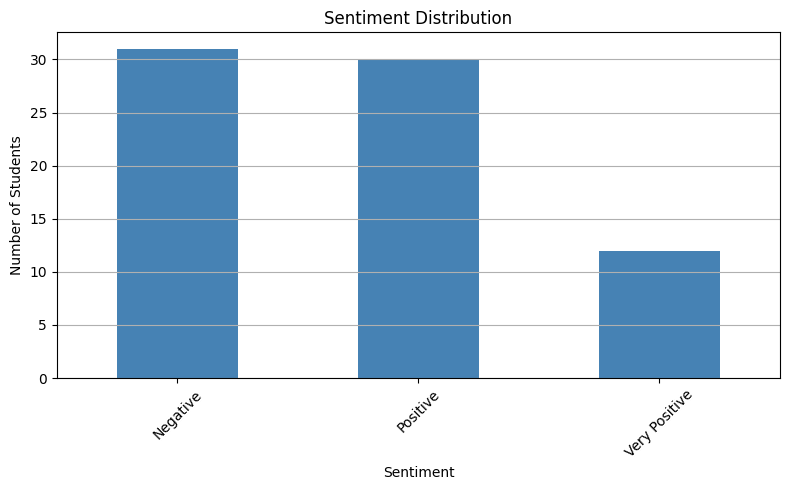

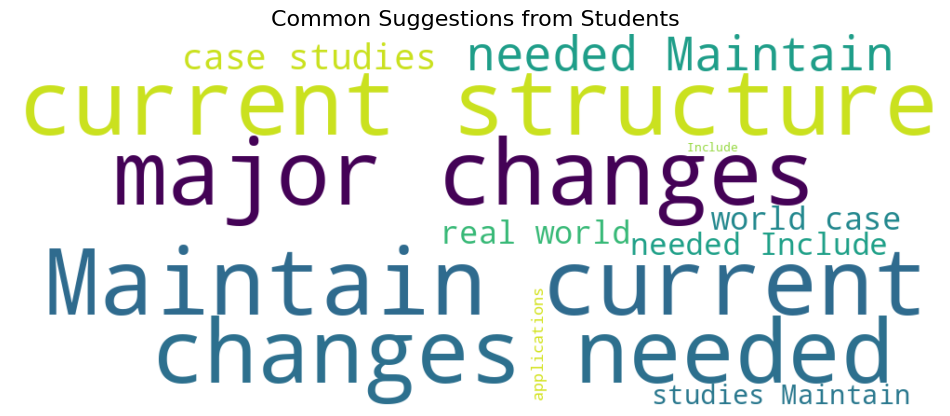

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Load your output CSV
df = pd.read_csv("final_course_sentiment_output.csv")  # Adjust path if needed

# -------------------------
# Sentiment Bar Chart
# -------------------------
plt.figure(figsize=(8, 5))
df['Sentiment'].value_counts().sort_index().plot(kind='bar', color='steelblue')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Students")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

# -------------------------
# Suggestion Word Cloud
# -------------------------
text = " ".join(df["Suggestion"].dropna().astype(str))
wordcloud = WordCloud(width=1000, height=400, background_color="white").generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Common Suggestions from Students", fontsize=16)
plt.show()
